# Bayesian Non-personalized Ranking

The main idea is that everything is a random variable. For instance, consider a binary variable x as a click (1) or no click (0) distributed as bernoilli random variable $$p(x) = \pi^{x}(1-\pi)^{1-x} .$$

In Bayesian paradigm $\pi$ is also a random variable. For instance, beta distributed $\pi$ $$p(\pi) = \frac{1}{B(\alpha, \beta)}\pi^{\alpha-1}(1-\pi)^(\beta-1)$$

$x$ is a discrete rv, it has a probability mass function, $\pi$ is continuous and it has a density function. Particularly, beta distribution allows $\pi$ to take any value between 0 and 1, and it represents probability of success (click in this case). We want to find the distribution $$p(\pi|X) = \frac{p(X|\pi)p(\pi)}{\int_0^1p(X|\pi)p(\pi)\mathrm{d}\pi}.$$

$p(\pi)$ is a prior distribution of $\pi$ and represents our prior believ on what the values of $\pi$ might be. $p(X|\pi)$ is the likelihood of the original click data points. In this situation, we choose $B(\alpha,\beta)$ as a prior distribution (uniform) since we do not have any bias toward $\pi$. Instead of calculating the complicated posterior distribution with the integral, we can avoid the integral since it is constant. The posterior is proportional to the numerator of the formula. We can plug in the values and get
\begin{aligned}
p(\pi|X) &\propto \pi^{\alpha-1}(1-\pi)^{\beta-1}\prod_{i=1}^{N}\pi^{X_i}(1-\pi)^{1-X_i} \\
&= \pi^{\alpha + (\sum_{i=1}^N X_i)-1}(1-\pi)^{\beta+N-(\sum_{i=1}^N X_i) - 1}
\end{aligned}

It can be seen from the above result that the posterior $$\pi\sim Beta(\alpha +\sum_{i=1}^N X_i, \beta+N-\sum_{i=1}^N X_i)$$

In code, we can iteratively update the posterior. We start with $\alpha = \beta = 1$, and for each sample, we update the beta distribution as $\alpha+=x_i$ and $\beta+=1-x_i$, and we use the new posterior as a prior for the next iteration. As we get more and more data this would converge to the true distribution.

This method does not always work. We are able to solve the problem easily in this case, because the posterior has a recognizable form. In this case, the prior is called conjugate prior which is a special case where posterior has the same type of distribution as the prior distribution. 

`The key trick of ranking items is that we draw samples from the posterior instead of using deterministic ranking. When there are not many samples of the item, the distribution is relatively evenly distributed unlike an item with many samples that has a more concentrated distribution. Initially, a random draw from fatter distribution may be a larger or smaller than the skinny distribution, therefore it automatically handles the tradeoff between exploration and exploitation. However, as we have more samples, the distribution will converge to the true distribution (will get skinnier).So sampling makes the ranking intelligently random that is controlled by the posterior distributions`

# Gaussian Conjugate Prior

* Likelihood: $$X\sim N(\mu, \tau^{-1})$$
* Prior: $$\mu\sim N(m_0, \lambda_0^{-1})$$
*Posterior: $$p(\mu|X) \propto e^{-\frac{\lambda_0}{2}(\mu - m_0)^2}\prod_{i=1}^{N}e^{-\frac{\tau}{2}(X_i-\mu)^2
}\\
\propto exp\Bigg[-\frac{1}{2}\Bigg\{(\lambda_0 + N \tau)\mu^2 - 2(m_0\lambda_0 + \tau\sum_{i=1}^N X_i)\mu +...\Bigg\}\Bigg]$$.
Similarly, density function of $$N(\mu, \lambda^{-1})$$ is proportional to
$$ \exp\Bigg(-\lambda\frac{(\mu-m)^2}{2}\Bigg)= \exp\Bigg(-\frac{1}{2}\Bigg\{\lambda \mu^2 - 2\lambda m \mu + ...\Bigg \}\Bigg)$$ 
hence from the correspondence between above two expressions, we get
$$
\lambda = \lambda_0 + N \tau \quad\text{and}\quad m\lambda = m_0\lambda_0 + \tau\sum_{i=1}^N X_i$$

which gives us normally distributed posterior defined as
$$p(\pi|X)\sim N(\frac{m_0\lambda_0 + \tau\sum_{i=1}^N X_i}{\lambda_0 + N \tau}, (\lambda_0 + N \tau)^{-1})$$

As $N\to\infty$, the posterior mean converges to the sample mean, and the variance goes to zero. 
We can see that the posterior mean is similar/equivalent to the smoothed average rating defined as
$$r = \frac{m_0\lambda_0/\tau + \sum_i X_i}{\lambda/\tau + N}$$


# Bayesian Personalized Rankings

[📚 Original post](https://towardsdatascience.com/recommender-system-using-bayesian-personalized-ranking-d30e98bba0b9)
[📚 Original Paper](https://arxiv.org/abs/1205.2618)

Summary:
```
**Implicit data**
 Implicit data is nothing but the feedback that we collect from customers in the form of clicks, purchases, 
 number of views e.t.c. Main features of implicit data are

1. No Negative feedback : In explicit data, customers express both their positive and negative feedback explicitly.
 Rest of the data points where there is no value are treated as missing values.
 But in implicit data, we have only positive feedback like clicks, purchases e.t.c and
  there is no way to tell if the missing data is because the customer did not like the item or is not aware of that
2. Inherently noisy : Although implicit data is inherently noisy, the sheer volume of it 
compensates for this drawback and helps in building robust recommender systems.
3. Preference vs confidence : In explicit data, ratings exclusively refer to customer’s preference
 with the numerical value showing the magnitude of preference. In case of implicit data,
  numerical value often refers to a frequency which might not necessarily reflect the magnitude of customer’s preference. 
Hence, there is a need to deduce a confidence metric that shows customer’s confidence

**Latent factor models**
For implicit data, Latent factor models provide an alternative approach to
 neighborhood models(models based on similarity measures) that helps in uncovering the latent features of users and items.
 Examples of such models are Matrix factorization, Latent semantic models, Latent dirichlet allocation e.t.c. Of them, 
 matrix factorization has become more popular due to its attractive accuracy and scalability.

Although a simple Singular value decomposition works for this purpose,
 it suffers from over-fitting which takes us to the next set of models which involve regularization.
```
**Data preparation**

Let U be the set of all users and I be the set of all items. 
Usual approach is to predict a personalized score xui for an item that reflects the preference of the user for the item. Here, all the existing interactions between user and item are labelled as a positive class(1) and the rest of the interactions are being labelled as negative class(0) .

This implies that if our model fits the training data exactly, it is going to treat all the interactions that are not present in the training data in the same manner as all of them are labelled as 0. This approach will not necessarily consider rank in the future recommendations.

In BPR approach, instead of taking one item, item pairs will be considered as training data. Optimization would be performed based on the rank of these user-item pairs instead of scoring just on the user-item interaction. 
user u1 has viewed item i2 but not item i1, so the algorithm assumes that this user prefers item i2 over i1( i2 > i1) and gives a positive sign. No inference can be made about a preference for items that were both been seen by a user and is shown as ? mark. The same is true for two items that a user has not seen yet (e.g. item i1 and i4 for user u1). On contrary, you can observe a negative sign for (i1,j2) as user prefers item2 over item1.

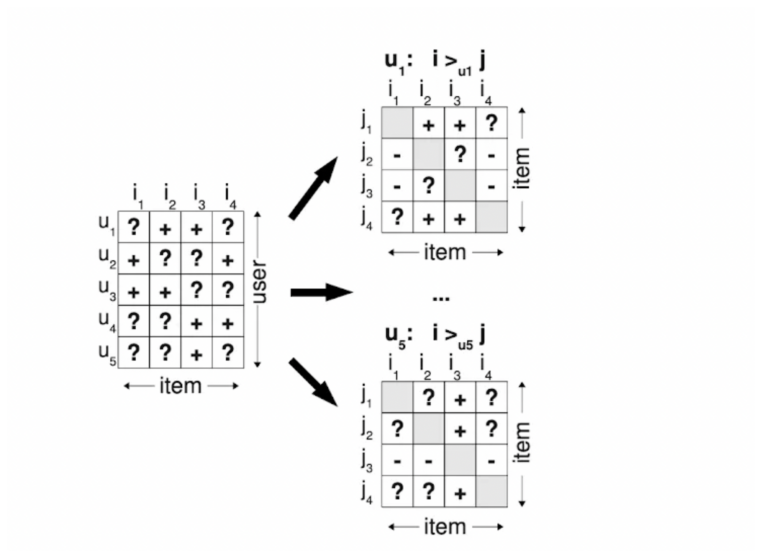

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
image = plt.imread('user_pos_neg.png')
plt.axis(False)
plt.imshow(image)

**Create Triplet Dataframe**

For each user, movies 4 or higher rating are labeld as a positive interaction and remaining rated movies are considered as a negative interaction. We create a triplet train dataframe in the form of `[user_id, positive_movie, negative_movie]`.
```
df_triplest = pd.DataFrame(columns=['user_id', 'positive_m_id', 'negative_m_id'])

data = []
users_without_data = []

for user_id in tqdm(df_train.user_id.unique()):
    positive_movies = df_train[(df_train.user_id == user_id) & (df_train.rating > 3)].movie_id.values
    negative_movies = df_train[(df_train.user_id == user_id) & (df_train.rating <= 3)].movie_id.values

    if negative_movies.shape[0] == 0 or positive_movies.shape[0] == 0:
        users_without_data.append(user_id)
        continue

    for positive_movie in positive_movies:
        for negative_movie in negative_movies:
            data.append({'user_id': user_id, 'positive_m_id': positive_movie, 'negative_m_id': negative_movie})

df_triplest = df_triplest.append(data, ignore_index=True)
```

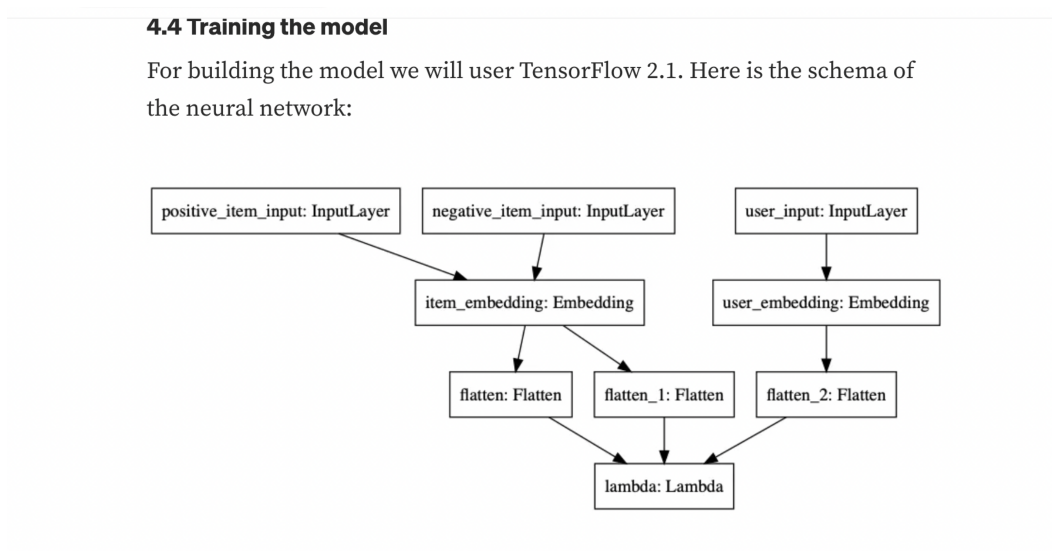

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
image = plt.imread('network.png')
plt.axis(False)
plt.imshow(image)

We have three inputs: a user, a positive item and a negative item.
Our **task is to make a difference between positive interaction and negative interaction significant**. In this case, the rank of the positive item should be higher than the rank for the negative item for a specific user:

**Multiplication of the dense layers for user and item is equal to the user-item interaction.**
We have two types of items but want to have one way to represent any of both. Technically, we will use a **single embedding layer for positive and negaive items**. This embedding layer shares the weights for the positive and negative items.
Finally, as the last layer, we use a **Lambda. That is a custom layer without any weights. We use it to wrap the function for calculation of triplet loss**. [original source article](https://medium.com/heyjobs-tech/building-recommendation-system-based-bayesian-personalized-ranking-using-tensorflow-2-1-b814d2704130) and [notebook for full code](https://github.com/DanilBaibak/movie-recommendation-system/blob/master/bpr_recommendation_system.ipynb)

**Create Triplet loss function**
Our objective is to maximize the difference 
$$x_{uij} = x_{ui}-x_{uj}$$
where $$x_{ui} = dot(emb_{u},emb_{i})$$, $u$ represents user and $i$ and $j$ represents positive and negative user-item. We want the the difference to be larger. Which is equivalent to formulate the loss function as
$$L = 1 - \frac{1}{1+e^{-x_{uij}}}$$ which is decreasing in $x_{uij}$ (decreasing in $x_{ui}$ and increasing in $x_{uj}$) and can be 0 at the minimum. To minimize this function, algorithm tries to increase positive interaction while decreasing and making negative interaction a negative value. This in turn helps to learn the true latent features of users and movies.

After training and learning the latent features of users and movies, the weights of embedding layers can be used to calculate the association between any user and movie, and can be used to rank the movies for each users. For the test set, we can isolate multiple 5 rating movies for a number of users, and we check if these movies come at the top of calculated rankings. These isolated movies are not included in the train set for the selected user, but are included for others.
```
@tf.function
def bpr_triplet_loss(X: dict):
    """
    Calculate triplet loss - as higher the difference between positive interactions
    and negative interactions as better
    :param X: X contains the user input, positive item input, negative item input
    :return:
    """
    positive_item_latent, negative_item_latent, user_latent = X

    positive_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, positive_item_latent), axis=-1, keepdims=True) # user similarity with positive movie
    negative_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, negative_item_latent), axis=-1, keepdims=True) # user similarity with negative movie

    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(positive_interactions, negative_interactions)))
```